In [1]:
import math
import os
import warnings
import h3

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd

import rasterio
from tqdm import tqdm
from rasterstats import zonal_stats

from shapely.geometry import LineString, Polygon, box
from shapely.ops import split

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

warnings.filterwarnings('ignore')

In [2]:
# World Image
# https://eoimages.gsfc.nasa.gov/images/imagerecords/73000/73909/world.topo.bathy.200412.3x5400x2700.jpg

# Population Dataset
# https://human-settlement.emergency.copernicus.eu/download.php?ds=pop

# Prepare the Base Worldmap Hex Grid

In [3]:
resolution = 1
west = gpd.GeoDataFrame(geometry=[box(-180, -89.9999, 1, 89.9999)], crs='EPSG:4326')
east = gpd.GeoDataFrame(geometry=[box(-1, -89.9999, 180, 89.9999)], crs='EPSG:4326')
merge = gpd.GeoDataFrame(geometry=[box(-10, -89.9999, 10, 89.9999)], crs='EPSG:4326')


In [4]:
from h3 import LatLngPoly, polygon_to_cells, cell_to_boundary

def polygon_to_h3_gdf(poly_gdf, resolution):
    """
    Convert a GeoDataFrame of polygons to H3 hexagons at a given resolution.
    Returns a GeoDataFrame of hexagons in EPSG:4326.
    """
    hex_polys_all = []
    hex_ids_all = []

    for geom in poly_gdf.geometry:
        # Skip empty geometries
        if geom.is_empty:
            continue

        # Exterior ring
        exterior = [(lat, lon) for lon, lat in geom.exterior.coords]

        # Interior rings (holes)
        holes = [[(lat, lon) for lon, lat in ring.coords] for ring in geom.interiors]

        # H3 polygon
        h3_poly = LatLngPoly(exterior, holes)

        # Generate H3 cell IDs
        hex_ids = polygon_to_cells(h3_poly, resolution)

        # Convert H3 cells to Polygons
        hex_polys = [Polygon([(lng, lat) for lat, lng in cell_to_boundary(h)]) for h in hex_ids]

        hex_polys_all.extend(hex_polys)
        hex_ids_all.extend(hex_ids)

    # Create GeoDataFrame
    hex_gdf = gpd.GeoDataFrame(
        {"h3_id": hex_ids_all},
        geometry=hex_polys_all,
        crs="EPSG:4326"
    )

    return hex_gdf


In [5]:
gdf_west = polygon_to_h3_gdf(west, resolution)
gdf_east = polygon_to_h3_gdf(east, resolution)
gdf_merge = polygon_to_h3_gdf(merge, resolution)

<Axes: >

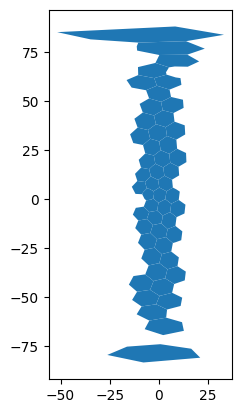

In [6]:
gdf_merge.plot()

In [7]:
gdf_global = pd.concat([gdf_west, gdf_east, gdf_merge], ignore_index=True)
gdf_global

,h3_id,geometry
0,818c7ffffffffff,"POLYGON ((101.92241 -11.98775, 100.83496 -7.94..."
1,81edbffffffffff,"POLYGON ((158.13911 -59.14601, 150.11766 -58.0..."
2,812d7ffffffffff,"POLYGON ((35.19779 45.67238, 39.93875 42.7363,..."
3,812fbffffffffff,"POLYGON ((158.8476 39.2723, 158.3829 43.9123, ..."
4,81957ffffffffff,"POLYGON ((122.89285 -2.72289, 123.69917 -7.171..."
...,...,...
882,81547ffffffffff,"POLYGON ((-9.00646 15.98599, -12.0717 12.84252..."
883,81387ffffffffff,"POLYGON ((3.54359 36.5979, 4.20417 32.11011, 8..."
884,81743ffffffffff,"POLYGON ((-6.0645 5.36274, -7.89984 3.55984, -..."
885,81983ffffffffff,"POLYGON ((-10.39281 -10.91927, -11.96375 -14.7..."


In [8]:
gdf_gobal = gdf_global.drop_duplicates(subset='h3_id')
gdf_global = gpd.GeoDataFrame(gdf_global, crs='EPSG:4326')

print(f'Total Hexes: {len(gdf_global)}')

Total Hexes: 887


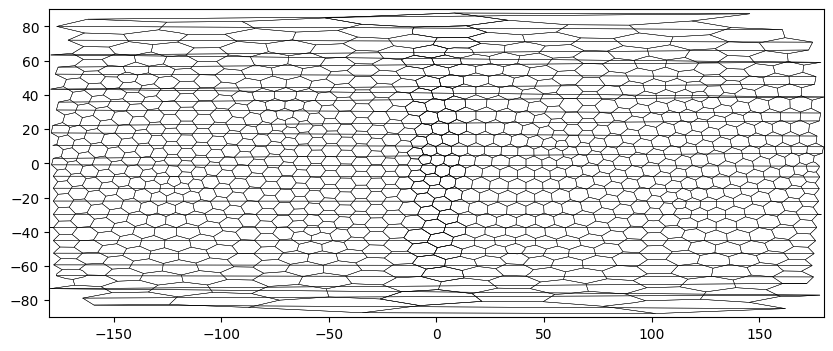

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10,4))
gdf_global.plot(ax=ax, edgecolor='k', color='none', linewidth=0.3)
ax.set_xlim(-180, 180)
ax.set_ylim(-90, 90)
ax.set_aspect('auto')
plt.show()

In [11]:
earth_img = mpimg.imread('12_world.topo.bathy.200412.3x5400x2700.jpg')
earth_arr = np.asarray(earth_img)

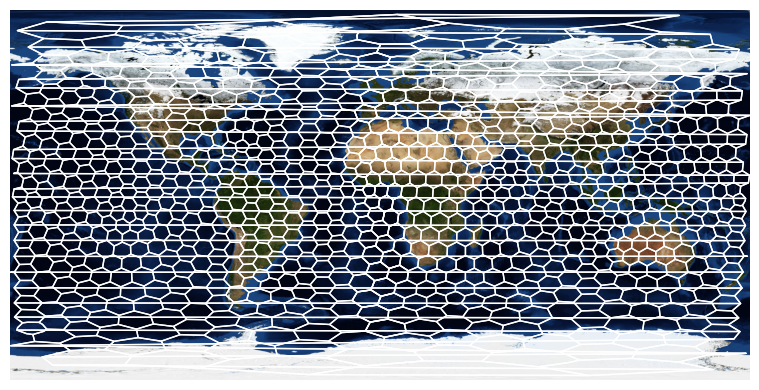

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10,4))
ax.imshow(earth_arr, extent=[-180, 180, -90, 90], origin='upper')
gdf_global.plot(ax=ax, color='None', edgecolor='w')
ax.axis('off')
plt.tight_layout()

# Max Population Levels to Hexagons

In [36]:
dataset_path = r'12- World Population'
os.listdir(dataset_path)

['GHS_POP_E1975_GLOBE_R2023A_4326_30ss_V1_0',
 'GHS_POP_E1980_GLOBE_R2023A_4326_30ss_V1_0',
 'GHS_POP_E1985_GLOBE_R2023A_4326_30ss_V1_0',
 'GHS_POP_E2005_GLOBE_R2023A_4326_30ss_V1_0',
 'GHS_POP_E2015_GLOBE_R2023A_4326_30ss_V1_0',
 'GHS_POP_E2020_GLOBE_R2023A_4326_30ss_V1_0',
 'GHS_POP_E2025_GLOBE_R2023A_4326_30ss_V1_0']

In [37]:
raster_dirs = sorted([d for d in os.listdir(dataset_path) if d.startswith('GHS_POP_E') and d.endswith('_GLOBE_R2023A_4326_30ss_V1_0')])
raster_dirs

['GHS_POP_E1975_GLOBE_R2023A_4326_30ss_V1_0',
 'GHS_POP_E1980_GLOBE_R2023A_4326_30ss_V1_0',
 'GHS_POP_E1985_GLOBE_R2023A_4326_30ss_V1_0',
 'GHS_POP_E2005_GLOBE_R2023A_4326_30ss_V1_0',
 'GHS_POP_E2015_GLOBE_R2023A_4326_30ss_V1_0',
 'GHS_POP_E2020_GLOBE_R2023A_4326_30ss_V1_0',
 'GHS_POP_E2025_GLOBE_R2023A_4326_30ss_V1_0']

In [38]:
# Compute zonal statistics in each grid for each year
for folder in tqdm(raster_dirs):
    year = folder.split('_')[2][1:] 
    raster_path = os.path.join(dataset_path, folder, f"{folder}.tif")

    stats = zonal_stats(
        gdf_global, raster_path, stats=['sum'], Nodata=None,
        geojson_out=False, all_touched=True, raster_out=False
    )

    gdf_global[f'population_{year}'] = [s['sum'] if s['sum'] is not None else 0 for s in stats]

100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [17:50<00:00, 152.89s/it]


In [39]:
gdf_global.head(3)

,h3_id,geometry,population_1975,population_1980,population_1985,population_2020,area_km2,density_1975,density_1980,density_1985,density_2020,population_2005,population_2015,population_2025
0,818c7ffffffffff,"POLYGON ((101.92241 -11.98775, 100.83496 -7.94...",5.690347e+02,5.598752e+02,5.740593e+02,5.455936e+02,593000.444000,0.000960,0.000944,0.000968,0.000920,5.876215e+02,5.635687e+02,5.203958e+02
1,81edbffffffffff,"POLYGON ((158.13911 -59.14601, 150.11766 -58.0...",0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,568354.261544,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
2,812d7ffffffffff,"POLYGON ((35.19779 45.67238, 39.93875 42.7363,...",2.471813e+07,2.520935e+07,2.587133e+07,2.528001e+07,602338.381221,41.036944,41.852470,42.951486,41.969785,2.574943e+07,2.546230e+07,2.411637e+07


In [40]:
# Normalize population to area of polygon 
equal_area_crs = 'EPSG:8857'
gdf_equal = gdf_global.to_crs(equal_area_crs)
gdf_global['area_km2'] = gdf_equal.geometry.area / 1e6

for col in [c for c in gdf_global.columns if c.startswith('population_')]:
    year = col.split('_')[1]
    gdf_global[f'density_{year}'] = gdf_global[col] / gdf_global['area_km2']

print(len(gdf_global))
gdf_global.head(3)

887


,h3_id,geometry,population_1975,population_1980,population_1985,population_2020,area_km2,density_1975,density_1980,density_1985,density_2020,population_2005,population_2015,population_2025,density_2005,density_2015,density_2025
0,818c7ffffffffff,"POLYGON ((101.92241 -11.98775, 100.83496 -7.94...",5.690347e+02,5.598752e+02,5.740593e+02,5.455936e+02,593000.444000,0.000960,0.000944,0.000968,0.000920,5.876215e+02,5.635687e+02,5.203958e+02,0.000991,0.000950,0.000878
1,81edbffffffffff,"POLYGON ((158.13911 -59.14601, 150.11766 -58.0...",0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,568354.261544,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
2,812d7ffffffffff,"POLYGON ((35.19779 45.67238, 39.93875 42.7363,...",2.471813e+07,2.520935e+07,2.587133e+07,2.528001e+07,602338.381221,41.036944,41.852470,42.951486,41.969785,2.574943e+07,2.546230e+07,2.411637e+07,42.749104,42.272424,40.037913


# Hexagon-Level Projections - 2125

In [68]:
# List all hexs
hexagons = list(gdf_global.h3_id)
len(hexagons)

887

In [69]:
h3_id = '815bbffffffffff'
df_hex = gdf_global[gdf_global.h3_id == h3_id].drop(columns = ['geometry', 'area_km2']).set_index('h3_id')

# Prepare time series df
df_hex = df_hex.T
df_hex = df_hex[df_hex.index.str.contains("density")]
df_hex['year'] = [int(str(i).split("_")[-1]) for i in df_hex.index]
df_hex = df_hex.set_index('year').rename(columns = {h3_id : 'density'})

df_hex

h3_id,density
year,
1975,10.250776
1980,11.583748
1985,13.095141
2020,26.571377
2005,20.155086
2015,24.319831
2025,28.778056


In [70]:
df_hex = df_hex.sort_values(by='year')
df_hex

h3_id,density
year,
1975,10.250776
1980,11.583748
1985,13.095141
2005,20.155086
2015,24.319831
2020,26.571377
2025,28.778056


In [71]:
# Forecasting population is not linear; there are several affecting factorrs -- > Several other prediction approaches

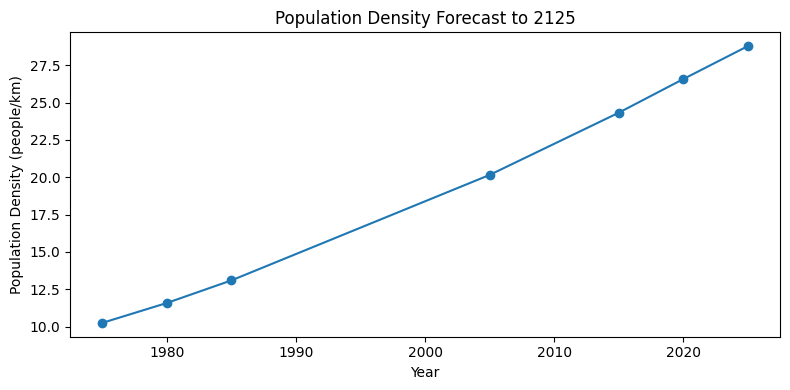

In [72]:
plt.figure(figsize=(8,4))
plt.plot(df_hex.index.astype(int).to_list(), df_hex.density.to_list(), 'o-', label='Observed', color='C0')
plt.xlabel('Year')
plt.ylabel('Population Density (people/km)')
plt.title('Population Density Forecast to 2125')
plt.tight_layout()
plt.show()

In [73]:
years = df_hex.index.astype(int).to_numpy()
density = df_hex['density'].astype(float).to_numpy()
print("years:", years)
print("density:", density)

t0 = years.min()
t = (years - t0).reshape(-1, 1)
future_years = np.arange(years.max() + 5, 2130, 5)
tf = (future_years - t0).reshape(-1, 1)

lin = LinearRegression().fit(t, density)
y_lin = lin.predict(tf)

years: [1975 1980 1985 2005 2015 2020 2025]
density: [10.25077615 11.58374781 13.09514067 20.15508579 24.31983096 26.57137722
 28.77805569]
t0: 1975
t shape: (7, 1)
t: [[ 0]
 [ 5]
 [10]
 [30]
 [40]
 [45]
 [50]]
density shape: (7,)
future_years: [2030 2035 2040 2045 2050 2055 2060 2065 2070 2075 2080 2085 2090 2095
 2100 2105 2110 2115 2120 2125]
tf shape: (20, 1)


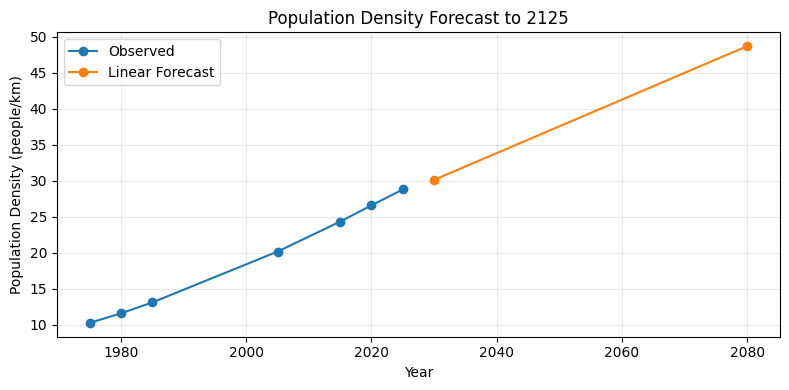

In [74]:
plt.figure(figsize=(8,4))
plt.plot(years, density, 'o-', label='Observed', color='C0')
plt.plot(future_years[0::10], y_lin[0::10], 'o-', label='Linear Forecast', color='C1')
plt.xlabel('Year')
plt.ylabel('Population Density (people/km)')
plt.title('Population Density Forecast to 2125')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [95]:
df_hex = df_hex.sort_index()
df_hex

h3_id,density
year,
1975,0.00096
1980,0.000944
1985,0.000968
2005,0.000991
2015,0.00095
2020,0.00092
2025,0.000878
2125,0.000818


In [107]:
def forecast_density_2125(df_hex, plot=True):
    if 'year' in df_hex.columns:
        years = df_hex['year'].astype(int).to_numpy()
    else:
        years = df_hex.index.astype(int).to_numpy()

    density = df_hex['density'].astype(float).to_numpy()

    t0 = years.min()
    t = (years - t0).reshape(-1, 1)
    future_years = np.arange(years.max() + 5, 2130, 5)
    tf = (future_years - t0).reshape(-1, 1)
    
    lin = LinearRegression().fit(t, density)
    y_lin = lin.predict(tf)

    t_2125 = np.array([[2125 - t0]])
    pred_2125 = float(lin.predict(t_2125)[0])

    return pred_2125


hexagons_2125 = {}

for h3_id in hexagons:
    df_hex = gdf_global[gdf_global.h3_id == h3_id].drop(columns=['geometry','area_km2']).set_index('h3_id')
    df_hex = df_hex.T
    df_hex = df_hex[df_hex.index.str.contains("density")]

    df_hex['year'] = [int(str(i).split("_")[-1]) for i in df_hex.index]
    df_hex = df_hex.set_index('year')

    df_hex = df_hex.rename(columns={col:'density'})
    df_hex['density'] = pd.to_numeric(df_hex['density'], errors='coerce')
    df_hex = df_hex.dropna()
    df_hex = df_hex.sort_index()
    hexagons_2125[h3_id] = forecast_density_2125(df_hex)

gdf_global['density_2125'] = gdf_global.h3_id.map(hexagons_2125)

gdf_global[['h3_id', 'density_2125', 'geometry']].head(3)

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by LinearRegression.

In [ ]:
gdf_global.plot(column = 'density_2125', cmap='Reds')

In [ ]:
# Compute Growth %
gdf_global['density_growth_pct'] = (
    (gdf_global['density_2125'] - gdf_global['density_2025']) / gdf_global['density_2025'] * 100
)

gdf_global['density_growth_pct'].replace([np.inf, -np.inf], np.nan, inplace=True)
gdf_global['density_growth_pct'].fillna(0, inplace=True) # shouldnt be done in proper scientific method
gdf_global['density_growth_pct'] = [
    math.log(x + 1) if x >=0 else 0
    for x in gdf_global['density_growth_pct']
]

vmin = gdf_global['density_growth_pct'].quantile(0.02)
vmax = gdf_global['density_growth_pct'].quantile(0.98)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
gdf_global.plot(
    column='density_growth_pct', cmap='Reds', vmin=vmin, vmax=vmax, ax=ax
)

ax.set_title('Log Population Density Growth 2025 - 2125 (%)', fontsize=14)
ax.axis('off')

# Fix the Boundaries of the Hexagon Grid (Periodic Boundary Condition)


In [ ]:
def detect_antimeridian_crossers(gdf):
    # Detect the hexs that wrap around the +-180 meridian == those whose long > 180
    def crosses_antimeridian(geom):
        if geom.is_empty:
            return False
        xs, xy = np.array(geom.exterior.coords).T
        return (xs.max() - xs.min()) > 180

    mask = gdf.geometry.apply(crosses_antimeridian)
    gdf_wrapped = gdf[mask].copy()
    return gdf_wrapped, mask

gdf_wrapped, mask = detect_antimeridian_crossers(gdf_global)
print('Total Hexes=', len(gdf_global))
print('Crossing the antimeridian=',len(gdf_wrapped))

In [ ]:
ax = gdf_global.boundary.plot(color='lightgray', linewidth=0.4, figsize=(12,6))
gdf_wrapped.boundary.plot(ax=ax, color='red', linewidth=1)
ax.set_xlim(-180, 180)
ax.set_ylim(-90, 90)
ax.set_aspect('auto')
ax.axis('off') 

In [ ]:
def fix_antimeridian_polygon(geom):
    # fix a poly crosses the +-180 meridian by snapping the minority side points to +-180 longitude
    if geom.is_empty:
        return geom

    xs, ys = np.array(geom.exterior.coords).T

    # determine which side left or right has the majority of vertices
    # to determine which side of the map this hex is supposed to be
    left_count = np.sum(xs < 0)
    right_count = np.sum(xs > = 0)
    majority_side = 'left' if left_count > right_count else 'right'

    new_xs = xs.copy()

    # Shift the minority_side points to the corresponding boundary
    for i, x in enumerate(xs):
        if majority_side == 'left' and x>0:
            new_xs[i] = - 179.999
        elif majority_side == 'right' and x<0:
            new_xs[i] = 179.999

    return Polygon(zip(new_xs, ys))

gdf_wraped_fixed = gdf_wrapped.copy()
gdf_wraped_fixed['geometry'] = gdf_wraped_fixed.geometry.apply(fix_antimeridian_polygon)

gdf_final = pd.concat([
    gdf_global[~mask], gdf_wrapped_fixed
], ignore_index=True)

gdf_final.crs = gdf_global.crs

# Plot for visual check
ax = gdf_final.boundary.plot(color='k', linewidth=0.4, figsize=(12,6))
ax.set_xlim(-180, 180)
ax.set_ylim(-90, 90)
ax.set_aspect('auto')
ax.axis('off') 

In [ ]:
ax = gdf_final.plot(column='density_growth_pct', cmap='Reds', linewidth=0.4, figsize=(12,6))
ax.set_xlim(-180, 180)
ax.set_ylim(-90, 90)
ax.set_aspect('equal')
ax.axis('off') 

In [ ]:
fig, ax = subplots(1, 1, figsize=(10,4))
ax.imshow(earth_arr. extent=[-180,180,-90,90], origin='upper')
gdf_final.plot(ax=ax, color='None', edgecolor='w')
ax = gdf_final.plot(column = 'density_growth_pct', cmap='Reds', linewidth=0.4, figsize=(12,6))
ax.axis('off') 
plt.tight_layout()

In [ ]:
fig, ax = subplots(1, 1, figsize=(10,4))
ax.imshow(earth_arr. extent=[-180,180,-90,90], origin='upper')

gdf_final['density_2125_log'] = np.where(
    gdf_final['density_2125'] > -1,
    np.log1p(gdf_final['density_2125']),
    0
)

gdf_final[gdf_final.population_2025>0].plot(column='density_2125_log', cmap='magma', edgecolor='k', linewidth=0.5)
ax.axis('off')
plt.tight_layout()